Классификация

In [90]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
import graphviz
import re


# file_path = './online_shoppers_intention.csv'
file_path = './adult 3 (1).csv'

df = pd.read_csv(file_path)
df = df.replace('?', pd.NA).dropna()
print(f"Размер: {df.shape}")

Размер: (45222, 15)


income - целевая переменная (булевая)

In [91]:
df_only_num = df[['age', 'hours-per-week']]

print(df_only_num.describe())

numeric_columns = df_only_num.columns


for col in df_only_num.columns:
    mode_value = df_only_num[col].mode()
    if not mode_value.empty:
        print(f"Мода для столбца '{col}': {mode_value.iloc[0]}")
    else:
        print(f"Мода для столбца '{col}' не найдена.")

print("\nАсимметрия:")
for col in numeric_columns:
    skew_val = skew(df[col].dropna())
    print(f"{col:20s}: {skew_val:8.3f}")

print("\nЭксцесс:")
for col in numeric_columns:
    kurt_val = kurtosis(df[col].dropna())
    print(f"{col:20s}: {kurt_val:8.3f}")

                age  hours-per-week
count  45222.000000    45222.000000
mean      38.547941       40.938017
std       13.217870       12.007508
min       17.000000        1.000000
25%       28.000000       40.000000
50%       37.000000       40.000000
75%       47.000000       45.000000
max       90.000000       99.000000
Мода для столбца 'age': 36
Мода для столбца 'hours-per-week': 40

Асимметрия:
age                 :    0.533
hours-per-week      :    0.341

Эксцесс:
age                 :   -0.156
hours-per-week      :    3.201


age:

Значения моды, медианы и средн. довольно близки (36, 37 и 38.5 соответственно). Эксцесс близок к нулю (-0.156), есть небольшая правосторонняя ассиметрия (0.533). Распределение близко к нормальному, но не является таковым.

hours-per-week:

Значения моды, медианы и средн. одинаковы (40). Есть небольшая правосторонняя ассиметрия (0.341), однако эксцесс довольно высокий (3.201), . Распределение тоже довольно близко к нормальному, но не является таковым.

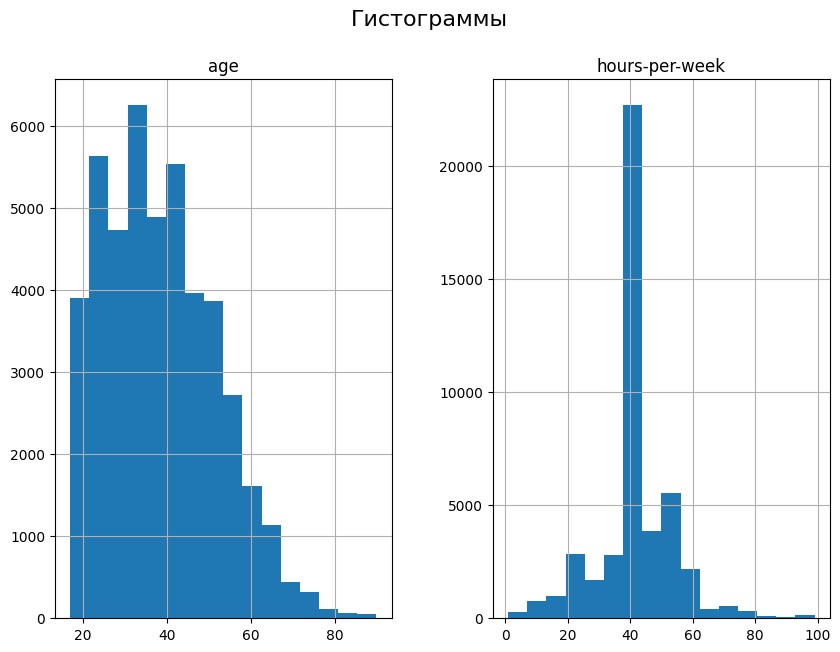

In [92]:

count_intervals = int(1 + math.log2(df_only_num.shape[0]))

df_only_num.hist(bins=count_intervals, figsize=(10, 7))
plt.suptitle("Гистограммы", fontsize=16)
plt.show()

In [93]:
df_only_categ = df[['income', 'educational-num', 'marital-status', 
                    'relationship', 'race', 'gender']]

for col in df_only_categ.columns:
    print(df_only_categ[col].value_counts(normalize=True) * 100)
    print("-" * 30)

income
<=50K    75.215603
>50K     24.784397
Name: proportion, dtype: float64
------------------------------
educational-num
9     32.689841
10    21.889788
13    16.739640
14     5.559241
11     4.331962
7      3.580116
12     3.332449
6      2.704436
4      1.819911
15     1.735881
5      1.494848
8      1.275928
16     1.202954
3      0.992880
2      0.490912
1      0.159215
Name: proportion, dtype: float64
------------------------------
marital-status
Married-civ-spouse       46.559197
Never-married            32.280748
Divorced                 13.924638
Separated                 3.120163
Widowed                   2.823847
Married-spouse-absent     1.220645
Married-AF-spouse         0.070762
Name: proportion, dtype: float64
------------------------------
relationship
Husband           41.276370
Not-in-family     25.876786
Own-child         14.652160
Unmarried         10.587767
Wife               4.623856
Other-relative     2.983061
Name: proportion, dtype: float64
-----------------

In [94]:
le_income = LabelEncoder()
le_marital = LabelEncoder()
le_relationship = LabelEncoder()
le_race = LabelEncoder()
le_gender = LabelEncoder()

df['income_num'] = le_income.fit_transform(df['income'])
df['marital_status_num'] = le_marital.fit_transform(df['marital-status'])
df['relationship_num'] = le_relationship.fit_transform(df['relationship'])
df['race_num'] = le_race.fit_transform(df['race'])
df['gender_num'] = le_gender.fit_transform(df['gender'])

print("\n income_num:")
print(sorted(df['income_num'].unique()))
print("\n marital_status_num:")
print(sorted(df['marital_status_num'].unique()))
print("\n relationship_num:")
print(sorted(df['relationship_num'].unique()))
print("\n race_num:")
print(sorted(df['race_num'].unique()))
print("\n gender_num:")
print(sorted(df['gender_num'].unique()))

columns_to_drop = ['income', 'fnlwgt', 'native-country', 'education',
                   'workclass', 'marital-status', 'occupation', 'relationship',
                   'race', 'gender', 'capital-gain', 'capital-loss']
df = df.drop(columns=columns_to_drop)

print("Столбцы после удаления:")
print(df.columns.tolist())


 income_num:
[np.int64(0), np.int64(1)]

 marital_status_num:
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

 relationship_num:
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

 race_num:
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

 gender_num:
[np.int64(0), np.int64(1)]
Столбцы после удаления:
['age', 'educational-num', 'hours-per-week', 'income_num', 'marital_status_num', 'relationship_num', 'race_num', 'gender_num']


Стандартизация для числовых переменных (если надо будет)

In [95]:
# numeric_columns = ['age', 'hours-per-week'] 
# df_scaled = df.copy()

# scaler = StandardScaler()

# # Применяем fit_transform только к числовым колонкам
# df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# df = df_scaled
# print("Средние значения после стандартизации:")
# print(df[numeric_columns].mean())

# print("\nСтандартные отклонения после стандартизации:")
# print(df[numeric_columns].std())

МЕТОД 1: дерево решений

Аргументация выбора метода дерева решений:

1. Интерпретируемость результата.
Деревья решений создают модель, которую легко понять и интерпретировать. Структура дерева напоминает процесс принятия решений человеком: на каждом узле проверяется условие (например, "возраст > 30"), и ветвление происходит в зависимости от результата. 
2. Работа с категориальными и числовыми признаками.
Мы работаем с датасетом, содержащим как числовые, так и категориальные переменные. Деревья решений могут обрабатывать оба типа данных без предварительного преобразования.
3. Нечувствительность к масштабу данных.
В отличие от методов, таких как SVM или нейронные сети, деревья решений не требуют масштабирования или нормализации признаков.

Точность: 0.7510226644555003

Отчёт классификации:
               precision    recall  f1-score   support

           0       0.93      0.73      0.82      6842
           1       0.49      0.83      0.62      2203

    accuracy                           0.75      9045
   macro avg       0.71      0.78      0.72      9045
weighted avg       0.82      0.75      0.77      9045



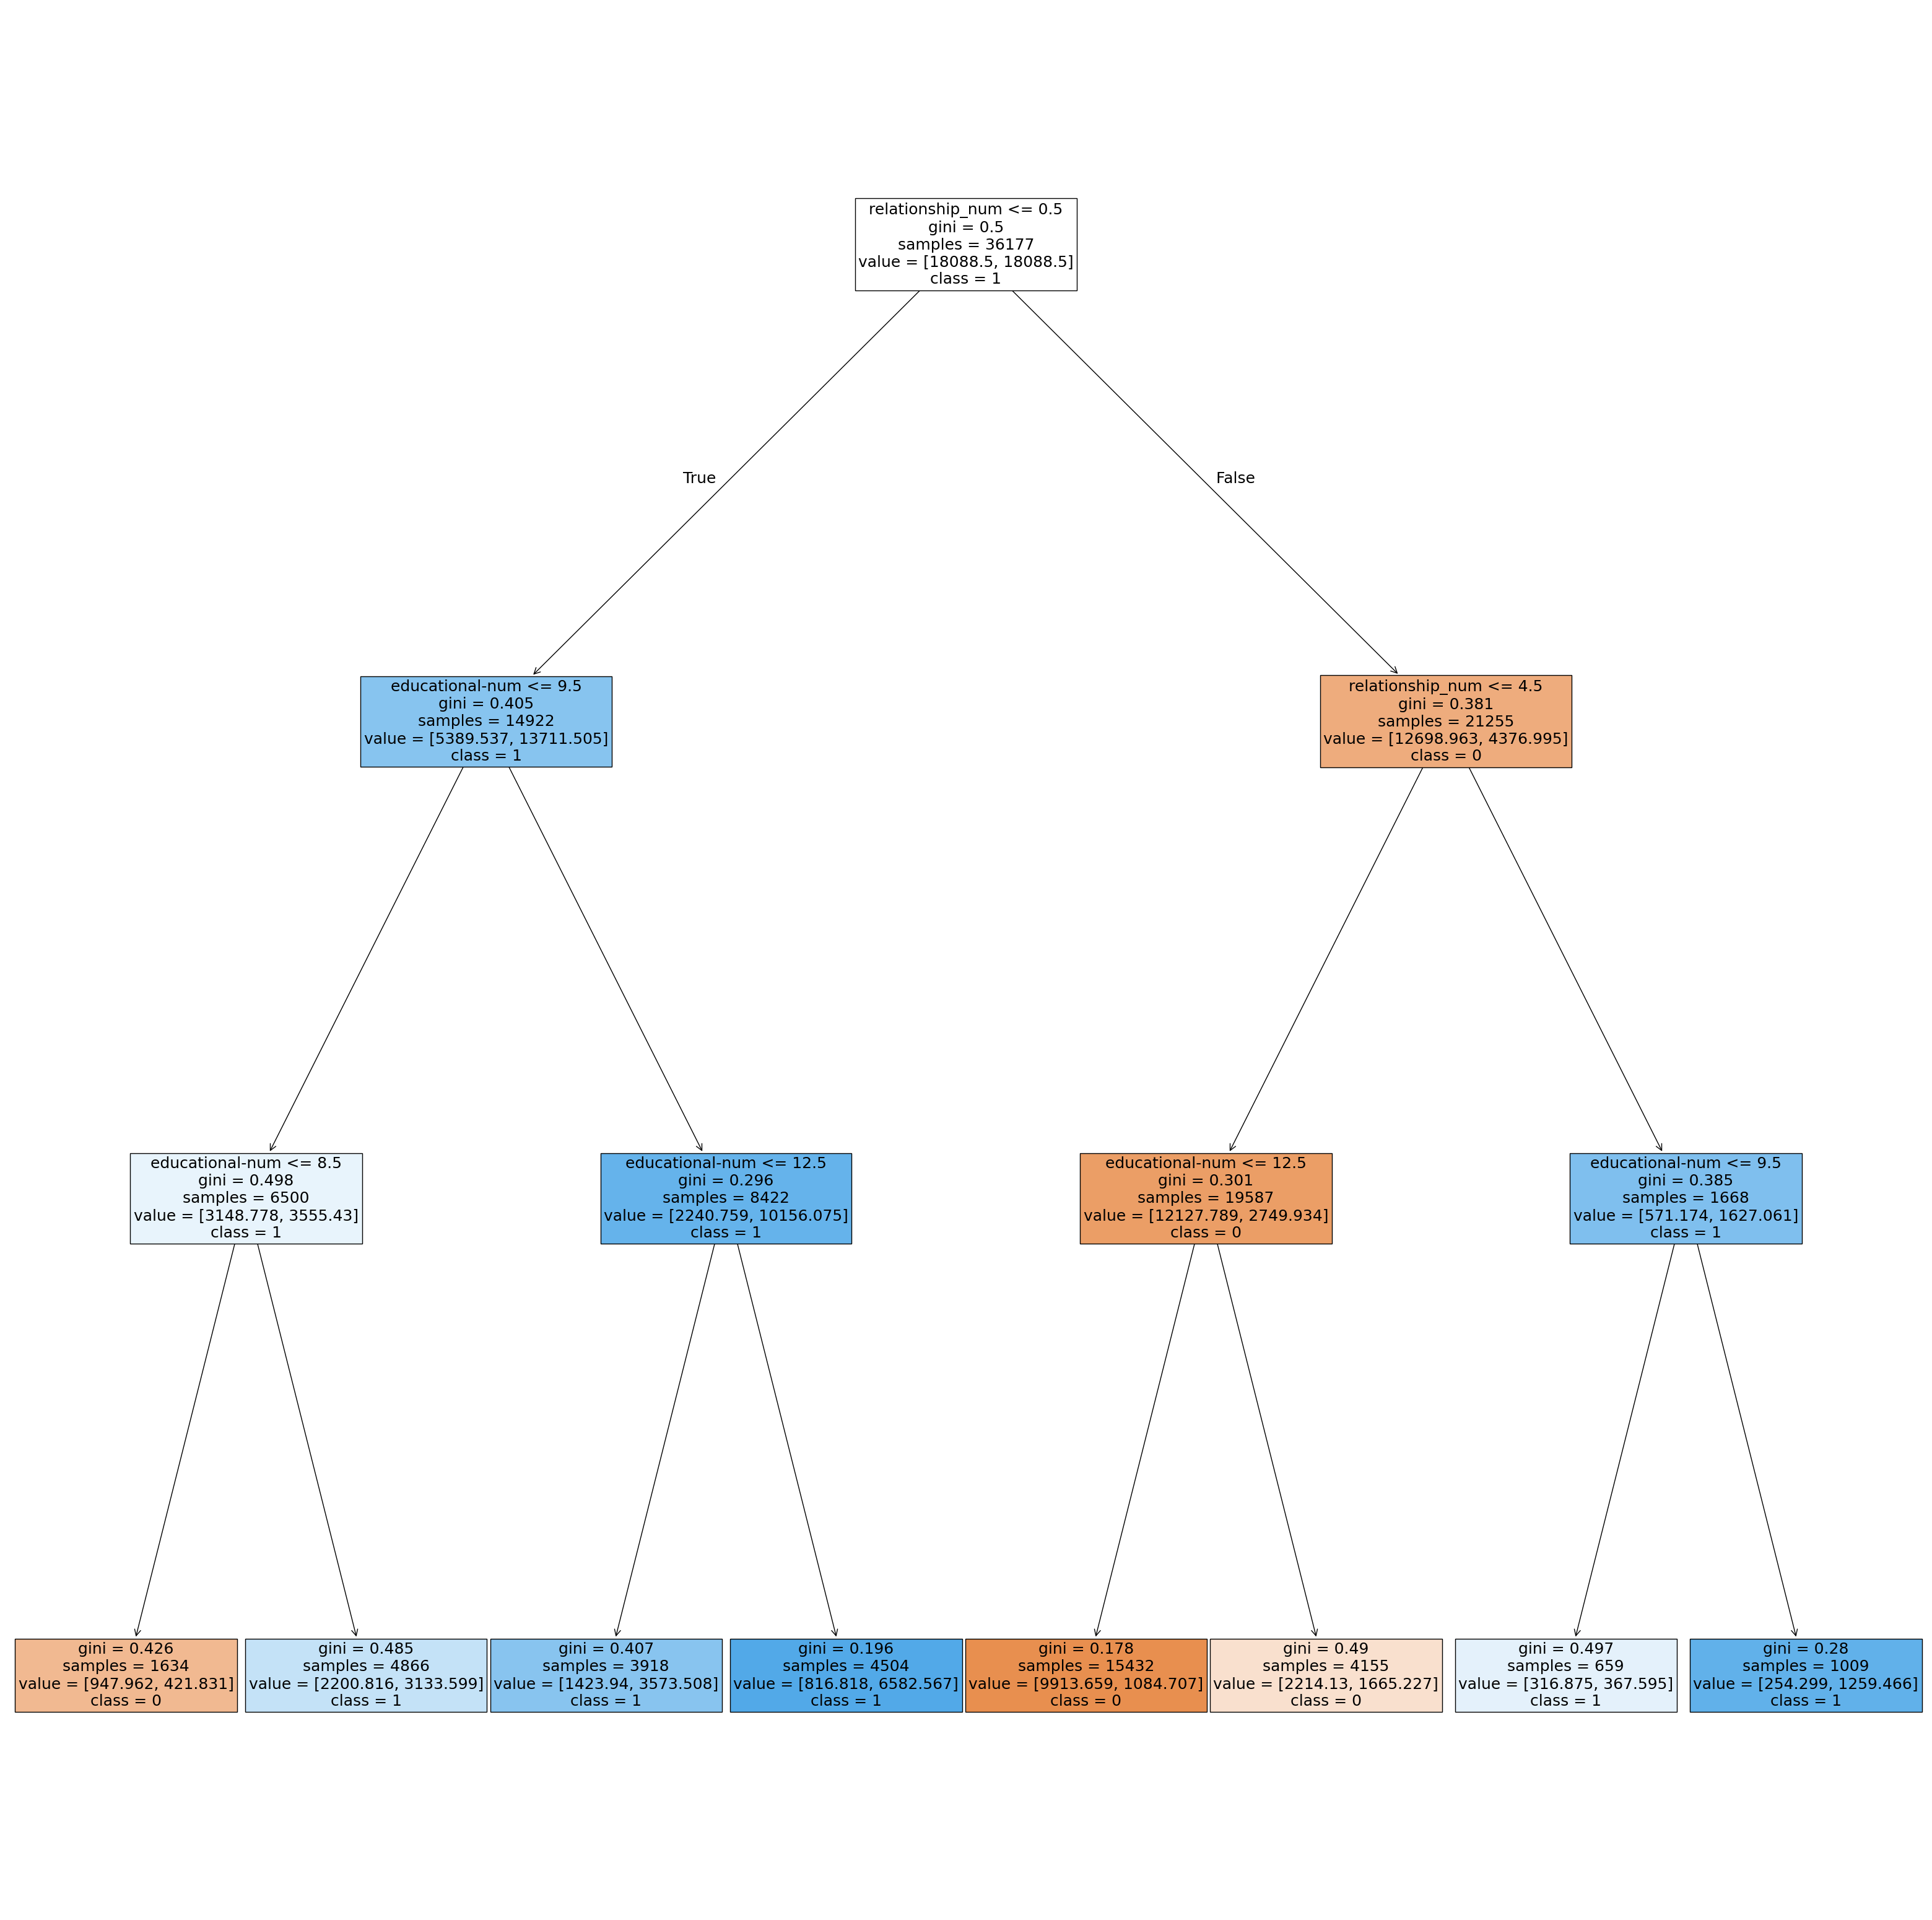

In [ ]:
X = df.drop('income_num', axis=1)  # все столбцы, кроме целевой
y = df['income_num']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели дерева решений
clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=3, 
    class_weight='balanced',
    min_samples_split=10,  # минимум 10 образцов для разбиения
    min_samples_leaf=5,    # минимум 5 в листе
    criterion='gini'       
)

# Обучение модели
clf.fit(X_train, y_train)

# Предсказания
y_pred = clf.predict(X_test)

# Оценка точности
print("Точность:", accuracy_score(y_test, y_pred))
print("\nОтчёт классификации:\n", classification_report(y_test, y_pred))


plt.figure(figsize=(40, 40))
plot_tree(clf,
          filled=True,
          fontsize=18,
          max_depth=3,
          feature_names=X.columns,
          class_names=clf.classes_.astype(str),  # если классы числовые, преобразуем в строки
          )
plt.show()

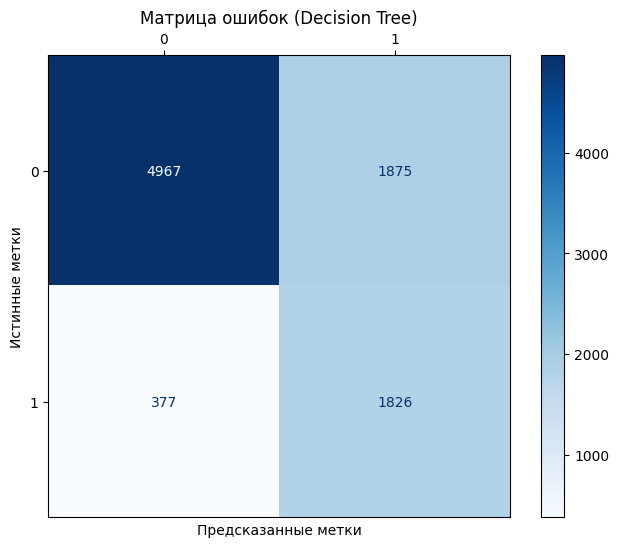

In [97]:
cm = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
fig, ax = plt.subplots(figsize=(8, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', values_format='d', ax=ax)

# Перемещаем метки классов на верхнюю ось (x-ось сверху)
ax.set_xlabel("Предсказанные метки")
ax.set_ylabel("Истинные метки")

# Добавляем метки классов НАВЕРХУ (как над столбцами)
ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

# Убираем подписи снизу (если нужно)
# ax.set_xticklabels([])  # если хотите полностью убрать нижние метки

plt.title("Матрица ошибок (Decision Tree)")
plt.show()



Важность признаков:
              feature  importance
4    relationship_num    0.737507
1     educational-num    0.262493
0                 age    0.000000
2      hours-per-week    0.000000
3  marital_status_num    0.000000
5            race_num    0.000000
6          gender_num    0.000000


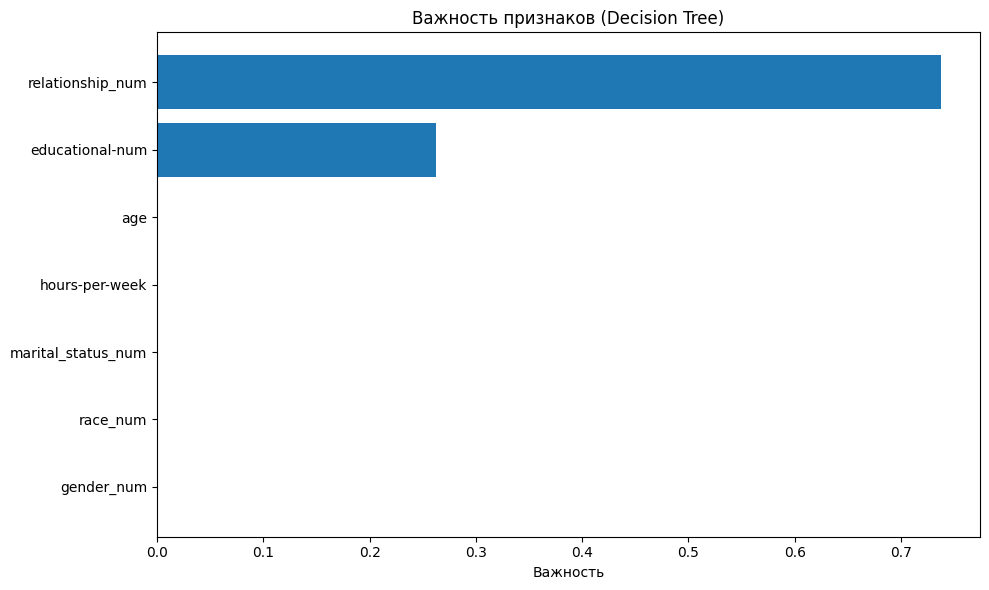

In [98]:
importances = clf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

print("Важность признаков:")
print(importance_df)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title("Важность признаков (Decision Tree)")
plt.xlabel("Важность")
plt.gca().invert_yaxis()  # чтобы самый важный был сверху
plt.tight_layout()
plt.show()